# EX 13. 인공지능으로 세상에 없던 새로운 패션 만들기

# 패키지 및 라이브러리 불러오기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


# 데이터셋 구성하기

In [2]:
# CIFAR-10 데이터 불러오기
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print("train_x shape:", train_x.shape)
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

print("-"*30)

# 정규화하지 않은 것
train_x_ = train_x
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

print("-"*30)

# 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

170500096/170498071 [==============================] - 2s 0us/step
train_x shape: (50000, 32, 32, 3)
max pixel: 255
min pixel: 0
------------------------------
max pixel: 255
min pixel: 0
------------------------------
max pixel: 1.0
min pixel: -1.0


In [3]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

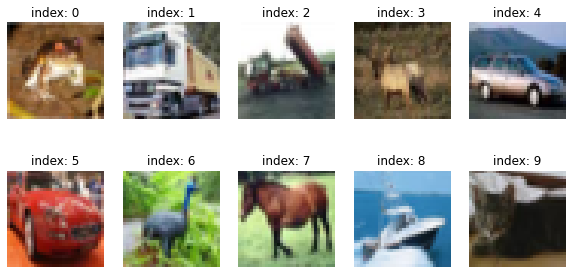

In [4]:
# 데이터 확인

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x_[i])     # 별도의 reshape 및 cmap 설정 불필요.
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

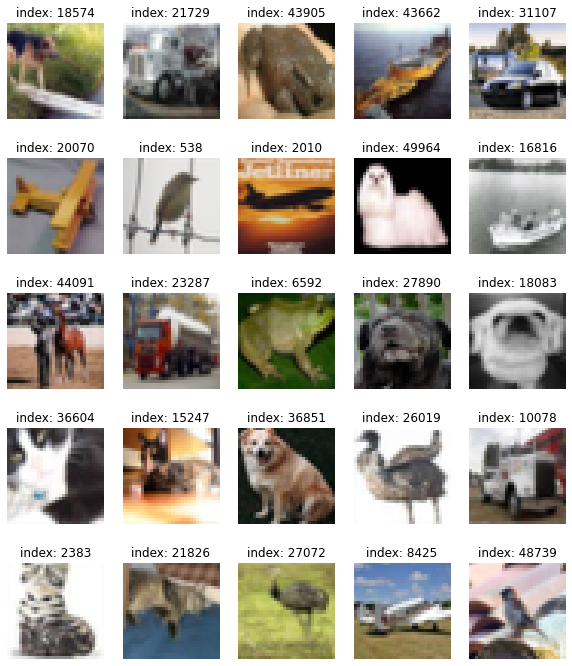

In [5]:
# 데이터셋에서 이미지 랜덤 추출

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x_[random_index])
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

- Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    - 다음 에러는 float32나 int32로 설정하면 이미지를 겹칠 때 발생하는 error이며 image값들이 모두 1로 변하여 합쳐진다.
    - 시각화해서 보는 데 별 문제가 없다.


## Hyperparameter

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
LEARNING_RATE = 1e-4  # 0.0001

- BUFFER_SIZE : 전체 데이터를 섞기 위해 50000으로 설정

## 데이터 나누기

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- tf.data.Dataset.from_tensor_slice()
    - list, numpy or tf.tensor 데이터셋을 만들 수 있음.
- train_x를 numpy로 shuffle 후 batch size로 나눔

# 생성자 모델 구현하기

- 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것

In [8]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) # default alpha=0.3

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Add: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

# 판별자 모델 구현하기
- Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

In [10]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Add: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Add: Conv2D layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

# 손실함수와 최적화 함수 구현하기

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- 진짜인지 가짜인지 나타내는 2개 클래스 간 분류 문제이므로 BinaryCrossentropy 사용
- from_logits = True
    - BinaryCrossentropy에 입력된 값을 함수 내부에서 sigmoid를 사용해서 0-1 사이의 값으로 정규화한 후 알맞게 계산할 수 있다.

## generator_loss / discriminator_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- generator_loss는 fake_output과 1에 가까워져야 하므로 tf.ones_like와의 cross_entropy 값을 계산하면 됨
    - fake_output이 1에 가까울수록 작은 값을 가짐.
- discriminator_loss에서 real_output 값은 1에 가까워져야 하고 fake_output은 0에 가까워져야 함.(두 가지 loss값을 모두 계산)
    - 1과 0으로 채워진 벡터를 서로 비교

## discriminator accuracy
- real output / fake output를 얼마나 정확히 판별하는지 accuracy 계산
    - 두 accuracy를 따로 계산하여 확인
    - real output / fake output는 accuracy가 1에 가까우면 좋지 않음
    - 초반에는 1.0에서 시작하다가 서서히 낮아져서 0.5에 가까워지는 것이 좋음.

In [16]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## Optimization

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# 훈련과정 상세 기능 구현하기

In [18]:
# 매번 학습이 어떻게 진행되는지 확인을 위해 생성자가 생성한 샘플을 확인
noise_dim = 100  # 고정된 100차원의 noise 설정          
num_examples_to_generate = 16  # sample의 개수

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

- 생성한 샘플은 매번 같은 노이즈로 생성해야 진전 과정을 확인할 수 있다고 함.

In [19]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

- (1) 입력데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
- (2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함
- (3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기
- (4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성
- (5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력
- (6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산
- (7) accuracy 계산 : fake_output, real_output으로 discriminator가
- (8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산
- (9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신
- (10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [20]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False) # 결과값이 나오는 부분

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        temp_invcal = predictions.numpy()
        temp_invcal = (temp_invcal * 127.5) + 127.5 # [0, 255]로 스케일링(역산)
        temp_invcal = temp_invcal.astype(int)
        plt.subplot(4, 4, i+1)
        plt.imshow(temp_invcal[i]) # 역산한 값 넣기
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

- 한 번의 훈련 과정이 train_step으로 끝나고 이어서 일정 간격으로 학습 현황을 보기 위한 샘플을 생성하는 함수.

# 학습 과정 진행하기
## 학습 과정 체크

In [21]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [22]:
# model checkpoint
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 학습

In [23]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [24]:
save_every = 5
EPOCHS = 600

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

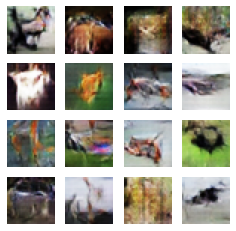

Time for training : 20868 sec


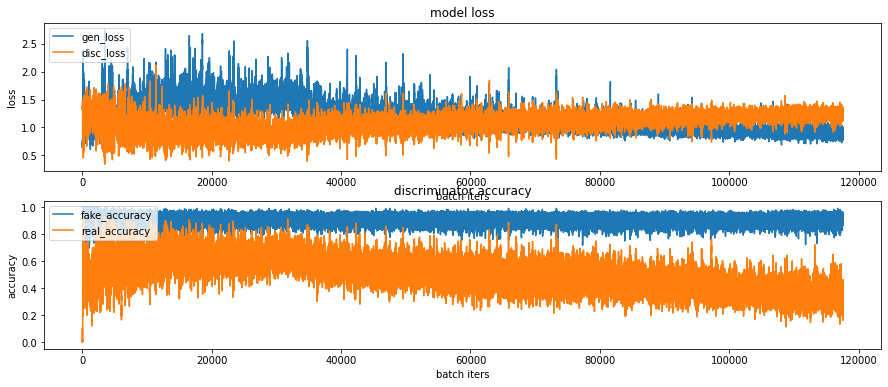

CPU times: user 4h 28min 50s, sys: 1h 21min, total: 5h 49min 50s
Wall time: 5h 47min 53s


In [25]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [26]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 4323947 Nov  9 07:40 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


# GAN 훈련 과정 개선하기

- 1차 시도
    - epochs : 100
    - 일정 구간에서 더 이상 accuracy와 loss가 개선되지 못함.
- 2차 시도
    - epochs : 200
    - 학습을 반복하면 "더 완벽한 이미지를 생성해내지 않을까?"라는 생각에 더 돌려보았음
    - 이미지를 확인했지만 형상만 어렴풋이 잡힘.
- 3차 시도
    - epochs : 300
    - 계층적 표현을 더 잘 학습하게 하기 위해 Layer를 더 쌓음.
    - 추가로 epochs을 더 늘렸음
- Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    - 이 error는 정규화를 하면서 -1과 1사이의 값을 넣었기 때문에 출력 값을 시각화 해보면 RGB값인 0-255의 모든 pixcel이 살아나지 않아서 이미지가 어둡게 나오는 문제가 생긴다.
    - stackoverflow를 참고했을 때 0-255의 이미지는 type이 int, uint가 들어가야하고 0-1인 경우 float가 들어가야한다고 한다. 그래서 위의 이미지를 출력할 때 정규화하지 않은 값을 넣었다.
        - https://stackoverflow.com/questions/62296165/solving-clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1
    - 출력되는 값은 정규화해서 넣은 값은 -1, 1 사이의 값이라 generate_and_save_images함수에서 역산(inverse calculation)을 통해 0-255로 바꾼다.

In [29]:
from IPython.display import Image
Image(open('fashion_mnist_dcgan.gif','rb').read()) # 학습 진행 결과

FileNotFoundError: [Errno 2] No such file or directory: 'fashion_mnist_dcgan.gif'

In [28]:
Image(open('GAN_300_epochs.PNG','rb').read()) # 학습 최종 결과 및 학습상태 확인

FileNotFoundError: [Errno 2] No such file or directory: 'GAN_300_epochs.PNG'

- 결과적으로 이미지를 제대로 생성하려면 더 많은 epochs을 돌려야 될 것 같다.
- 모델의 구조를 다르게 변경해봐야한다. 예를들면 batch_normalization이나 dropout의 위치를 바꾸거나 빼주거나 LeakyReLU의 alpha 값 조정 등의 많은 선택지가 있다.
- fake_acc와 real_acc가 0.5로 맞춰지지 못했다. real_acc는 상당히 잘 되어가고 있는 것으로 보아 epochs을 더 늘려준다면 더 나은 성능을 기대할 수 있을 것 같다.
- 어느 정도의 깨끗하고 형상화 된 이미지를 생성했으나 아직까지 알아보기 힘들었다.

Jeon0866 님 코드 참고
https://github.com/Jeon0866/AIFFEL_Project/blob/master/E13_CIFAR10_DCGAN.ipynb

# CIFAR-10 이미지 생성하기
평가문항|상세기준
---|---
1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.|오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.
2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.|gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.
3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.|제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.